## Imports 

In [1]:
from caserec.recommenders.rating_prediction.nnmf import NNMF
from caserec.recommenders.rating_prediction.ae import AE
from keras import initializers

C:\Anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [1]:
# Make the import
import os, sys
import pandas as pd
import joblib
import numpy as np
from caserec.utils.split_database import SplitDatabase
import matplotlib.pyplot as plt
%matplotlib inline 
from IPython.display import clear_output

lib_path = './../Sources/Utilities'
if (lib_path not in sys.path):
    sys.path.append(lib_path) #src directory

from messaging.print_functions import ProgressBar
from messaging.telegrambot import Bot
bot = Bot(user_credentials='./JFGS.json')

# Checking if bot is ok
# bot.send_message(text="Hello, John")
progbar = ProgressBar(bar_length=20, bar_fill='#', elapsed_time=True)

## Setting Dataset

In [2]:
dataset, dataset_type = 'MovieLens', '100k'
# dataset, dataset_type = 'BookCrossing', 'Standard'
# dataset, dataset_type = 'Amazon', 'MoviesTV'
# dataset, dataset_type = 'Amazon', 'InstantVideo'
# dataset, dataset_type = 'Jester', 'jester'

dataset_folder = "../Datasets/" + dataset + "/" + dataset_type + "/"
dataset_output_folder = dataset_folder + 'outputs/'

df_overall_sparsity = pd.read_csv(dataset_output_folder + 'df_overall_sparsity.tsv', sep='\t', header=0)
df_overall_sparsity.head()

,uss_limit,iss_limit,os,num_users,num_items
0,0.1,0.10,0.000000,2.0,1.0
1,0.1,0.11,0.000000,2.0,1.0
2,0.1,0.12,0.000000,2.0,1.0
3,0.1,0.13,0.333333,2.0,3.0
4,0.1,0.14,0.250000,2.0,4.0


In [4]:
sparsity_datasets_folder = dataset_output_folder + 'sparsity_datasets/'
sparsity_folders = os.listdir(sparsity_datasets_folder)
if 'desktop.ini' in sparsity_folders:    
    sparsity_folders.remove('desktop.ini')

## Creating Evaluation Function

In [42]:

def eval_model(**kwargs):
    
    predictions_output_filepath = './predictions_output_' + kwargs['model_name'].lower() + '.dat'
    
    if (kwargs['model_name'].lower() == 'item-knn'):
        from caserec.recommenders.item_recommendation.itemknn import ItemKNN
        from caserec.evaluation.rating_prediction import RatingPredictionEvaluation
        from caserec.utils.process_data import ReadFile
        
        model = ItemKNN(
                        train_file=kwargs['train_filepath'], 
                        test_file=kwargs['test_filepath'],                         
        #                 as_binary=True, # If True, the explicit feedback will be transform to binary
                        k_neighbors=kwargs['k_neighbors'],
                        similarity_metric='cosine', #kwargs['similarity_metric'],
                        output_file=predictions_output_filepath,
                        rank_length=kwargs['top_n'])

        model.compute(
            metrics=None, 
            as_table=True,
            n_ranks=[kwargs['top_n']],
            verbose=False)        
        
        eval_results = model.evaluation_results

        reader = ReadFile(input_file=predictions_output_filepath)
        predictions = reader.read()

        # Creating evaluator with item-recommendation parameters
        evaluator = RatingPredictionEvaluation(sep = '\t', as_rank = False)

        # Getting evaluation
        temp_eval_results = evaluator.evaluate(predictions['feedback'], model.test_set)

        eval_results['MAE'] = temp_eval_results['MAE']
        eval_results['RMSE'] = temp_eval_results['RMSE']
        
    elif (kwargs['model_name'].lower() == 'nnmf'):  
        from caserec.recommenders.rating_prediction.nnmf import NNMF
        from caserec.utils.process_data import ReadFile
        from caserec.evaluation.rating_prediction import RatingPredictionEvaluation
        
        model = NNMF(kwargs['train_filepath'], 
                      kwargs['test_filepath'], 
                      factors=kwargs['n_factors'],
                     output_file = predictions_output_filepath)
        
        model.compute(verbose=False)
        
        # Using ReadFile class to read predictions from file
        reader = ReadFile(input_file=predictions_output_filepath)
        predictions = reader.read()
        
        # Creating evaluator with item-recommendation parameters
        evaluator = RatingPredictionEvaluation(sep = '\t', 
                                               n_rank = [kwargs['top_n']], 
                                               as_rank = True,
                                               metrics = list(kwargs['metrics']))

        # Getting evaluation
        eval_results = evaluator.evaluate(predictions['feedback'], model.test_set)
        
        eval_results['MAE'] = model.evaluation_results['MAE']
        eval_results['RMSE'] = model.evaluation_results['RMSE']
        
    elif (kwargs['model_name'].lower() == 'ae'):  
        from caserec.recommenders.rating_prediction.ae import AE        
        from caserec.utils.process_data import ReadFile
        from caserec.evaluation.rating_prediction import RatingPredictionEvaluation
        
        model = AE(kwargs['train_filepath'], 
                   kwargs['test_filepath'], 
                   num_neurons=kwargs['num_neurons'],
                   kernel_initializer=kwargs['kernel_initializer'],
                   output_file = predictions_output_filepath)
        
        model.compute(verbose=False)
        
        # Using ReadFile class to read predictions from file
        reader = ReadFile(input_file=predictions_output_filepath)
        predictions = reader.read()
        
        # Creating evaluator with item-recommendation parameters
        evaluator = RatingPredictionEvaluation(sep = '\t', 
                                               n_rank = [kwargs['top_n']], 
                                               as_rank = True,
                                               metrics = list(kwargs['metrics']))

        # Getting evaluation
        eval_results = evaluator.evaluate(predictions['feedback'], model.test_set)    
        
        eval_results['MAE'] = model.evaluation_results['MAE']
        eval_results['RMSE'] = model.evaluation_results['RMSE']
        
    elif (kwargs['model_name'].lower() == 'bprmf'):  
        from caserec.recommenders.item_recommendation.bprmf import BprMF
        
        model = BprMF(kwargs['train_filepath'], 
                      kwargs['test_filepath'], 
                      batch_size=30, 
                      rank_length = kwargs['top_n'])
        
        model.compute(
            metrics=None, 
            as_table=True)
        
        eval_results = model.evaluation_results

    eval_results['uss_limit'] = kwargs['uss_limit']
    eval_results['iss_limit'] = kwargs['iss_limit']

    os.remove(predictions_output_filepath)
    
    return eval_results    


## Creating list of argument to evaluation function

In [48]:
df_overall_sparsity = df_overall_sparsity[df_overall_sparsity['iss_limit'] >= 0.2]
df_overall_sparsity = df_overall_sparsity[df_overall_sparsity['uss_limit'] >= 0.2]

In [50]:
top_n = 10
model_name = 'item-knn'
metrics = ('PREC', 'RECALL', 'NDCG', 'MAP')

# Item KNN Parameters
k_neighbors = 30
similarity_metric= 'cosine'
# NNMF Parameters
n_factors = 30
# Auto encoder parameters 
# kernel_initializer=initializers.random_uniform()
# num_neurons = 400

arr_eval_args = []

for index, row in df_overall_sparsity.iterrows():    
    progbar.update_progress(index/float(df_overall_sparsity.shape[0]))
        
    fold_num = 0
    n_folds = 2
    
    uss_limit = row['uss_limit']
    iss_limit = row['iss_limit']
    
    target_folder = 'usslimit_{}_isslimit_{}'.format(uss_limit, iss_limit)

    if target_folder not in sparsity_folders:
        print ("Error findind " + target_folder + " folder")    
        break
    else:        
        # Visualize file content
        ratings_filepath = sparsity_datasets_folder + target_folder + '/u.data'
        cross_validation_folder = sparsity_datasets_folder + target_folder + '/'

        try:
        
            SplitDatabase(input_file=ratings_filepath, dir_folds = cross_validation_folder, n_splits=n_folds).k_fold_cross_validation()

        except : 
            print ("Erro em ", ratings_filepath)
            break
            
        fold_path = cross_validation_folder + 'folds/' + str(fold_num)

        train_filepath = fold_path + '/train.dat'
        test_filepath = fold_path + '/test.dat'

        temp_eval_args = {'uss_limit': uss_limit,
                          'iss_limit': iss_limit,
                          'model_name': model_name,                           
                          'metrics': metrics,
                          'train_filepath': train_filepath, 
                          'test_filepath': test_filepath, 
                          'top_n': top_n, 
                          'k_neighbors': k_neighbors, # KNN
                          'similarity_metric': similarity_metric, # KNN
# #                           'n_factors': n_factors, # NNMF
#                           'kernel_initializer': kernel_initializer, # AE
#                           'num_neurons': num_neurons # AE
                         }

        arr_eval_args.append(temp_eval_args)

text = "Finished creating arr_eval_args for {} on {}/{} dataset in {}".format(model_name, dataset, dataset_type, progbar.get_elapsed_time())
joblib.dump(arr_eval_args, dataset_output_folder + 'arr_eval_args_' + model_name + '.joblib')
bot.send_message(text=text)

[0:57:52][####################] 100.00% Done...
[0:57:52][####################] 100.00% Done...
[0:57:52][####################] 100.00% Done...
[0:57:52][####################] 100.00% Done...
[0:57:52][####################] 100.00% Done...
[0:57:52][####################] 100.00% Done...
[0:57:53][####################] 100.00% Done...
[0:57:53][####################] 100.00% Done...
[0:57:53][####################] 100.00% Done...
[0:57:53][####################] 100.00% Done...
[0:57:53][####################] 100.00% Done...
[0:57:53][####################] 100.00% Done...
[0:57:53][####################] 100.00% Done...
[0:57:53][####################] 100.00% Done...
[0:57:54][####################] 100.00% Done...
[0:57:54][####################] 100.00% Done...
[0:57:54][####################] 100.00% Done...
[0:57:54][####################] 100.00% Done...
[0:57:54][####################] 100.00% Done...
[0:57:54][####################] 100.00% Done...
[0:57:54][####################] 100.00% 

[0:59:03][####################] 100.00% Done...
[0:59:03][####################] 100.00% Done...
[0:59:03][####################] 100.00% Done...
[0:59:03][####################] 100.00% Done...
[0:59:03][####################] 100.00% Done...
[0:59:03][####################] 100.00% Done...
[0:59:03][####################] 100.00% Done...
[0:59:04][####################] 100.00% Done...
[0:59:04][####################] 100.00% Done...
[0:59:04][####################] 100.00% Done...
[0:59:04][####################] 100.00% Done...
[0:59:04][####################] 100.00% Done...
[0:59:04][####################] 100.00% Done...
[0:59:04][####################] 100.00% Done...
[0:59:05][####################] 100.00% Done...
[0:59:05][####################] 100.00% Done...
[0:59:05][####################] 100.00% Done...
[0:59:05][####################] 100.00% Done...
[0:59:05][####################] 100.00% Done...
[0:59:05][####################] 100.00% Done...
[0:59:06][####################] 100.00% 

[1:00:20][####################] 100.00% Done...
[1:00:20][####################] 100.00% Done...
[1:00:20][####################] 100.00% Done...
[1:00:21][####################] 100.00% Done...
[1:00:21][####################] 100.00% Done...
[1:00:21][####################] 100.00% Done...
[1:00:21][####################] 100.00% Done...
[1:00:21][####################] 100.00% Done...
[1:00:21][####################] 100.00% Done...
[1:00:22][####################] 100.00% Done...
[1:00:22][####################] 100.00% Done...
[1:00:22][####################] 100.00% Done...
[1:00:22][####################] 100.00% Done...
[1:00:22][####################] 100.00% Done...
[1:00:23][####################] 100.00% Done...
[1:00:23][####################] 100.00% Done...
[1:00:23][####################] 100.00% Done...
[1:00:23][####################] 100.00% Done...
[1:00:24][####################] 100.00% Done...
[1:00:24][####################] 100.00% Done...
[1:00:24][####################] 100.00% 

[1:01:40][####################] 100.00% Done...
[1:01:41][####################] 100.00% Done...
[1:01:41][####################] 100.00% Done...
[1:01:41][####################] 100.00% Done...
[1:01:41][####################] 100.00% Done...
[1:01:42][####################] 100.00% Done...
[1:01:42][####################] 100.00% Done...
[1:01:42][####################] 100.00% Done...
[1:01:43][####################] 100.00% Done...
[1:01:43][####################] 100.00% Done...
[1:01:43][####################] 100.00% Done...
[1:01:44][####################] 100.00% Done...
[1:01:44][####################] 100.00% Done...
[1:01:45][####################] 100.00% Done...
[1:01:45][####################] 100.00% Done...
[1:01:45][####################] 100.00% Done...
[1:01:46][####################] 100.00% Done...
[1:01:46][####################] 100.00% Done...
[1:01:47][####################] 100.00% Done...
[1:01:47][####################] 100.00% Done...
[1:01:47][####################] 100.00% 

[1:03:10][####################] 100.00% Done...
[1:03:11][####################] 100.00% Done...
[1:03:11][####################] 100.00% Done...
[1:03:11][####################] 100.00% Done...
[1:03:12][####################] 100.00% Done...
[1:03:12][####################] 100.00% Done...
[1:03:13][####################] 100.00% Done...
[1:03:13][####################] 100.00% Done...
[1:03:13][####################] 100.00% Done...
[1:03:14][####################] 100.00% Done...
[1:03:14][####################] 100.00% Done...
[1:03:15][####################] 100.00% Done...
[1:03:15][####################] 100.00% Done...
[1:03:16][####################] 100.00% Done...
[1:03:17][####################] 100.00% Done...
[1:03:17][####################] 100.00% Done...
[1:03:18][####################] 100.00% Done...
[1:03:18][####################] 100.00% Done...
[1:03:19][####################] 100.00% Done...
[1:03:20][####################] 100.00% Done...
[1:03:20][####################] 100.00% 

[1:04:45][####################] 100.00% Done...
[1:04:45][####################] 100.00% Done...
[1:04:46][####################] 100.00% Done...
[1:04:46][####################] 100.00% Done...
[1:04:47][####################] 100.00% Done...
[1:04:47][####################] 100.00% Done...
[1:04:48][####################] 100.00% Done...
[1:04:49][####################] 100.00% Done...
[1:04:50][####################] 100.00% Done...
[1:04:50][####################] 100.00% Done...
[1:04:51][####################] 100.00% Done...
[1:04:52][####################] 100.00% Done...
[1:04:53][####################] 100.00% Done...
[1:04:53][####################] 100.00% Done...
[1:04:54][####################] 100.00% Done...
[1:04:55][####################] 100.00% Done...
[1:04:56][####################] 100.00% Done...
[1:04:57][####################] 100.00% Done...
[1:04:58][####################] 100.00% Done...
[1:04:59][####################] 100.00% Done...
[1:05:00][####################] 100.00% 

[1:06:27][####################] 100.00% Done...
[1:06:28][####################] 100.00% Done...
[1:06:29][####################] 100.00% Done...
[1:06:30][####################] 100.00% Done...
[1:06:31][####################] 100.00% Done...
[1:06:32][####################] 100.00% Done...
[1:06:33][####################] 100.00% Done...
[1:06:34][####################] 100.00% Done...
[1:06:35][####################] 100.00% Done...
[1:06:36][####################] 100.00% Done...
[1:06:37][####################] 100.00% Done...
[1:06:38][####################] 100.00% Done...
[1:06:39][####################] 100.00% Done...
[1:06:40][####################] 100.00% Done...
[1:06:42][####################] 100.00% Done...
[1:06:43][####################] 100.00% Done...
[1:06:44][####################] 100.00% Done...
[1:06:46][####################] 100.00% Done...
[1:06:47][####################] 100.00% Done...
[1:06:48][####################] 100.00% Done...
[1:06:50][####################] 100.00% 

[1:08:19][####################] 100.00% Done...
[1:08:20][####################] 100.00% Done...
[1:08:21][####################] 100.00% Done...
[1:08:22][####################] 100.00% Done...
[1:08:24][####################] 100.00% Done...
[1:08:26][####################] 100.00% Done...
[1:08:28][####################] 100.00% Done...
[1:08:29][####################] 100.00% Done...
[1:08:30][####################] 100.00% Done...
[1:08:31][####################] 100.00% Done...
[1:08:33][####################] 100.00% Done...
[1:08:34][####################] 100.00% Done...
[1:08:36][####################] 100.00% Done...
[1:08:37][####################] 100.00% Done...
[1:08:39][####################] 100.00% Done...
[1:08:40][####################] 100.00% Done...
[1:08:42][####################] 100.00% Done...
[1:08:43][####################] 100.00% Done...
[1:08:45][####################] 100.00% Done...
[1:08:45][####################] 100.00% Done...
[1:08:45][####################] 100.00% 

[1:10:18][####################] 100.00% Done...
[1:10:20][####################] 100.00% Done...
[1:10:21][####################] 100.00% Done...
[1:10:23][####################] 100.00% Done...
[1:10:25][####################] 100.00% Done...
[1:10:27][####################] 100.00% Done...
[1:10:28][####################] 100.00% Done...
[1:10:30][####################] 100.00% Done...
[1:10:32][####################] 100.00% Done...
[1:10:34][####################] 100.00% Done...
[1:10:34][####################] 100.00% Done...
[1:10:34][####################] 100.00% Done...
[1:10:34][####################] 100.00% Done...
[1:10:34][####################] 100.00% Done...
[1:10:34][####################] 100.00% Done...
[1:10:35][####################] 100.00% Done...
[1:10:35][####################] 100.00% Done...
[1:10:35][####################] 100.00% Done...
[1:10:35][####################] 100.00% Done...
[1:10:35][####################] 100.00% Done...
[1:10:35][####################] 100.00% 

In [ ]:
# del sparsity_folders   
del df_overall_sparsity
del sparsity_folders        

In [33]:
model_name = 'item-knn'
arr_eval_args = joblib.load(dataset_output_folder + 'arr_eval_args_' + model_name + '.joblib')

FileNotFoundError: [Errno 2] No such file or directory: '../Datasets/MovieLens/100k/outputs/arr_eval_args_item-knn.joblib'

### Testing evaluation function

In [ ]:
temp_eval_args = {'uss_limit': 1.0,
                          'iss_limit': 1.0,
                          'model_name': 'nnmf', 
                          'train_filepath': sparsity_datasets_folder + 'usslimit_{}_isslimit_{}/folds/0/train.dat'.format(1.0, 1.0), 
                          'test_filepath': sparsity_datasets_folder + 'usslimit_{}_isslimit_{}/folds/0/test.dat'.format(1.0, 1.0), 
                          'top_n': 10, 
#                           'k_neighbors': k_neighbors, 
                          'n_factors': 30,
                          'similarity_metric': 'cosine',
                          'metrics': ('PREC', 'RECALL', 'NDCG', 'MAP')}
temp_eval_args

In [ ]:
eval_model(**temp_eval_args)

In [43]:
arr_eval_args[1]

{'uss_limit': 0.1,
 'iss_limit': 0.11,
 'model_name': 'item-knn',
 'metrics': ('PREC', 'RECALL', 'NDCG', 'MAP'),
 'train_filepath': '../Datasets/MovieLens/100k/outputs/sparsity_datasets/usslimit_0.1_isslimit_0.11/folds/0/train.dat',
 'test_filepath': '../Datasets/MovieLens/100k/outputs/sparsity_datasets/usslimit_0.1_isslimit_0.11/folds/0/test.dat',
 'top_n': 10,
 'k_neighbors': 30}

In [51]:
eval_model(**arr_eval_args[0])

PREC@10	RECALL@10	MAP@10	NDCG@10	
0.3	1.0	0.833333	1.0	
Eval:: MAE: 2.633796 RMSE: 2.988925 


{'PREC@10': 0.3,
 'RECALL@10': 1.0,
 'NDCG@10': 1.0,
 'MAP@10': 0.833333,
 'MAP': 0.833333,
 'MAE': 2.633796,
 'RMSE': 2.988925,
 'uss_limit': 0.2,
 'iss_limit': 0.2}

In [ ]:
arr_eval_args = joblib.load(dataset_output_folder + 'arr_eval_args_' + model_name + '.joblib')

In [52]:
bot.send_message(text='Started creating df_eval_metadata')
max_evals = len(arr_eval_args)
for index, row in enumerate(arr_eval_args):
    current_save = int(10*index/float(max_evals)) 
    
    clear_output()
    progbar.update_progress(index/float(max_evals))    

    print (row)
    
#     if (index >= 15):
#         break
    
    eval_result = eval_model(**arr_eval_args[index])

    if (index == 0):
        colnames = list(eval_result.keys())
        df_eval_metadata = pd.DataFrame(columns = colnames)
        
    df_eval_metadata.loc[index] = [eval_result[x] for x in colnames]

df_eval_metadata.to_csv(dataset_output_folder + 'df_eval_metadata_' + model_name + '.tsv', sep = '\t', header = 1, index = 0 )
text = "Finished creating df_eval_metadata for {} on {}/{} dataset".format(model_name, dataset, dataset_type)
# bot.send_message(text=text)
import os
# os.system('shutdown -s')

[2:12:14][####################] 99.98% {'uss_limit': 1.0, 'iss_limit': 1.0, 'model_name': 'item-knn', 'metrics': ('PREC', 'RECALL', 'NDCG', 'MAP'), 'train_filepath': '../Datasets/MovieLens/100k/outputs/sparsity_datasets/usslimit_1.0_isslimit_1.0/folds/0/train.dat', 'test_filepath': '../Datasets/MovieLens/100k/outputs/sparsity_datasets/usslimit_1.0_isslimit_1.0/folds/0/test.dat', 'top_n': 10, 'k_neighbors': 30, 'similarity_metric': 'cosine'}
PREC@10	RECALL@10	MAP@10	NDCG@10	
0.468399	0.132774	0.622635	0.731244	
Eval:: MAE: 1.521684 RMSE: 1.84551 


In [53]:
df_eval_metadata.tail()

,PREC@10,RECALL@10,NDCG@10,MAP@10,MAP,MAE,RMSE,uss_limit,iss_limit
6556,0.472004,0.141905,0.736158,0.629578,0.629578,1.440328,1.756537,1.0,0.96
6557,0.475822,0.140670,0.743766,0.633606,0.633606,1.502108,1.821939,1.0,0.97
6558,0.466702,0.134024,0.738745,0.633534,0.633534,1.494674,1.823613,1.0,0.98
6559,0.474443,0.138496,0.742950,0.636726,0.636726,1.512784,1.836006,1.0,0.99
6560,0.468399,0.132774,0.731244,0.622635,0.622635,1.521684,1.845510,1.0,1.00


In [15]:
df_eval_metadata.to_csv(dataset_output_folder + 'df_eval_metadata_' + model_name + '.tsv', sep = '\t', header = 1, index = 0 )

### Checking memory usage

In [ ]:
import sys

# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Get a sorted list of the objects and their sizes
sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)

In [30]:
top_n = 10

## Plotting Results

### Ranking Metrics

In [54]:
model_name

'item-knn'

In [60]:
arr_rank_metrics = ['PREC@' + str(top_n), 'RECALL@' + str(top_n), 'NDCG@' + str(top_n), 'MAP@' + str(top_n)]
arr_rank_metrics

['PREC@10', 'RECALL@10', 'NDCG@10', 'MAP@10']

In [59]:
np.zeros([len(uss_limits), len(iss_limits)]).shape

(81, 81)

In [64]:
df_eval_metadata.head()

,PREC@10,RECALL@10,NDCG@10,MAP@10,MAP,MAE,RMSE,uss_limit,iss_limit
0,0.300000,1.000000,1.000000,0.833333,0.833333,2.633796,2.988925,0.2,0.20
1,0.300000,1.000000,0.833333,0.750000,0.750000,2.694117,3.132066,0.2,0.21
2,0.300000,1.000000,1.000000,0.833333,0.833333,3.317868,3.604100,0.2,0.22
3,0.233333,0.666667,0.666667,0.666667,0.666667,2.286383,2.640845,0.2,0.23
4,0.333333,1.000000,0.892701,0.880952,0.880952,2.952994,3.227790,0.2,0.24


In [70]:
df_eval_metadata[(df_eval_metadata['uss_limit'] == uss_limit) & (df_eval_metadata['iss_limit'] == iss_limit)]

,PREC@10,RECALL@10,NDCG@10,MAP@10,MAP,MAE,RMSE,uss_limit,iss_limit
0,0.3,1.0,1.0,0.833333,0.833333,2.633796,2.988925,0.2,0.2


In [72]:
uss_limits = df_eval_metadata['uss_limit'].unique()
iss_limits = df_eval_metadata['iss_limit'].unique()

# column = 'MAP@10'

for column in arr_rank_metrics:

    arr_prec = np.zeros([len(uss_limits), len(iss_limits)])
    for uss_index, uss_limit in enumerate(uss_limits):
        for iss_index, iss_limit in enumerate(iss_limits):            
            arr_prec[uss_index, iss_index] = df_eval_metadata[(df_eval_metadata['uss_limit'] == uss_limit) & (df_eval_metadata['iss_limit'] == iss_limit)][column].reset_index(drop = True)[0]

    joblib.dump(arr_prec, dataset_output_folder + 'arr_' + column.lower() + '_' + model_name + '.joblib')        

[*] Saving 2d-PREC@10-item-knn.png figure to ../Datasets/MovieLens/100k/outputs/Figures/ folder...
[+] Results saved.
[*] Saving 2d-RECALL@10-item-knn.png figure to ../Datasets/MovieLens/100k/outputs/Figures/ folder...
[+] Results saved.
[*] Saving 2d-NDCG@10-item-knn.png figure to ../Datasets/MovieLens/100k/outputs/Figures/ folder...
[+] Results saved.
[*] Saving 2d-MAP@10-item-knn.png figure to ../Datasets/MovieLens/100k/outputs/Figures/ folder...
[+] Results saved.


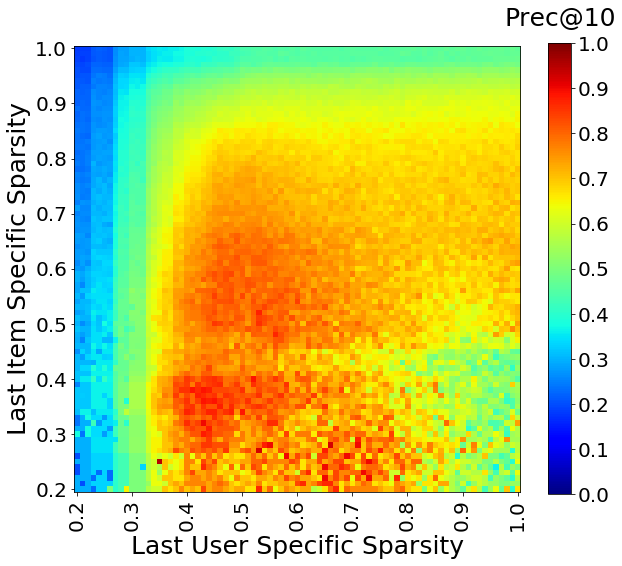

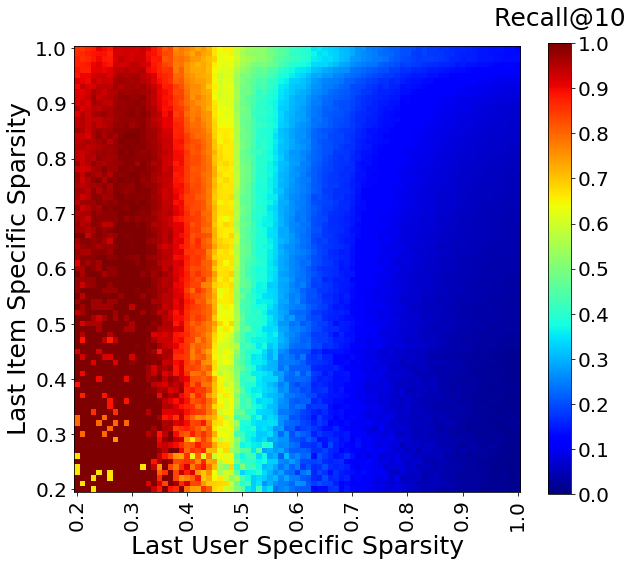

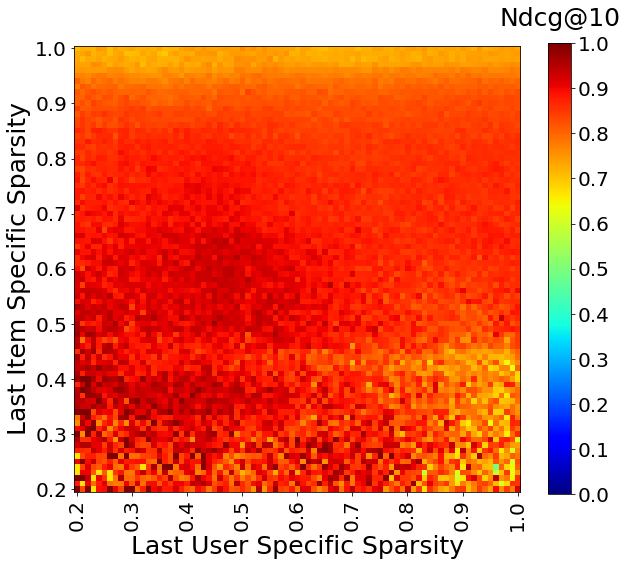

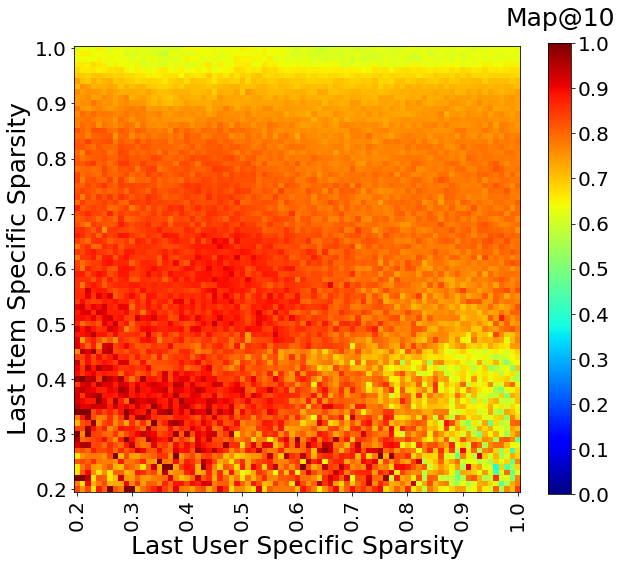

In [73]:
for column in arr_rank_metrics:

    arr_prec = joblib.load(dataset_output_folder + 'arr_' + column.lower() + '_' + model_name + '.joblib')        

    cmapping = "jet"
    fig, ax = plt.subplots(figsize=(10,10))

    # plt.subplot(1, 1, 1)
    cax = plt.imshow(arr_prec, cmap=cmapping)
    plt.gca().invert_yaxis()
    cbar = plt.colorbar(cax, ticks = [x/100.0 for x in np.arange(0,1000,10)], shrink = 0.83)
    # plt.colorbar.set_label('OS', labelpad=-50,  y=1.05, rotation=0, fontsize = label_fontsize)

    tick_step = int(10)

    ax.set_xticklabels(uss_limits[0:len(uss_limits):tick_step])
    ax.set_yticklabels(iss_limits[0:len(uss_limits):tick_step])

    plt.xticks(np.arange(0, len(uss_limits), tick_step))
    plt.yticks(np.arange(0, len(iss_limits), tick_step))

    plt.clim(0, 1)


    tick_fontsize = 20
    label_fontsize = 25

    # # Setting Labels
    ax.set_xlabel('Last User Specific Sparsity', fontsize = label_fontsize)
    ax.set_ylabel('Last Item Specific Sparsity', fontsize = label_fontsize)
    # cbar = fig.colorbar(cax, ticks = [x/100.0 for x in np.arange(0,1000,5)])

    plt.xticks(rotation = 'vertical')
    ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)
    cbar.set_label(column.title(), labelpad=-50,  y=1.08, rotation=0, fontsize = label_fontsize)
    cbar.ax.tick_params(labelsize = tick_fontsize)


    # Saving figure
    filename = '2d-' + column + '-' + model_name + '.png';
    fullpath = dataset_output_folder+'Figures/';
    print ("[*] Saving " + filename + " figure to " + fullpath + " folder...")
    fig.savefig(fullpath + filename, bbox_inches = 'tight')
    print ("[+] Results saved.")
    
#     bot.send_photo(bot_credentials['chat_id'], photo=open(fullpath + filename, 'rb'))

### Rating Prediction Metrics 

In [74]:
arr_rating_metrics = ['RMSE', 'MAE']

In [75]:
uss_limits = df_eval_metadata['uss_limit'].unique()
iss_limits = df_eval_metadata['iss_limit'].unique()

# column = 'MAP@10'
arr_rating_metrics = ['RMSE', 'MAE']

for column in arr_rating_metrics:

    arr_prec = np.zeros([len(uss_limits), len(iss_limits)])
    for uss_index, uss_limit in enumerate(uss_limits):
        for iss_index, iss_limit in enumerate(iss_limits):
            arr_prec[uss_index, iss_index] = df_eval_metadata[(df_eval_metadata['uss_limit'] == uss_limit) & (df_eval_metadata['iss_limit'] == iss_limit)][column].reset_index(drop = True)[0]

    joblib.dump(arr_prec, dataset_output_folder + 'arr_' + column.lower() + '_' + model_name + '.joblib')        

In [79]:
int(arr_prec.max())+1

8

[*] Saving 2d-RMSE-item-knn.png figure to ../Datasets/MovieLens/100k/outputs/Figures/ folder...
[+] Results saved.
[*] Saving 2d-MAE-item-knn.png figure to ../Datasets/MovieLens/100k/outputs/Figures/ folder...
[+] Results saved.


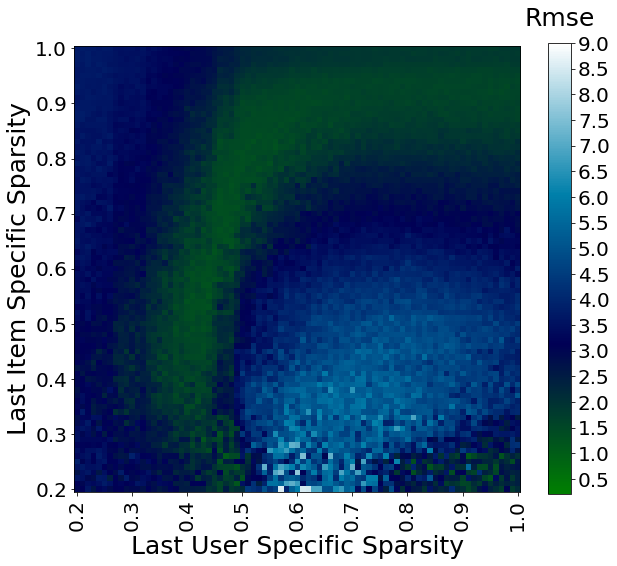

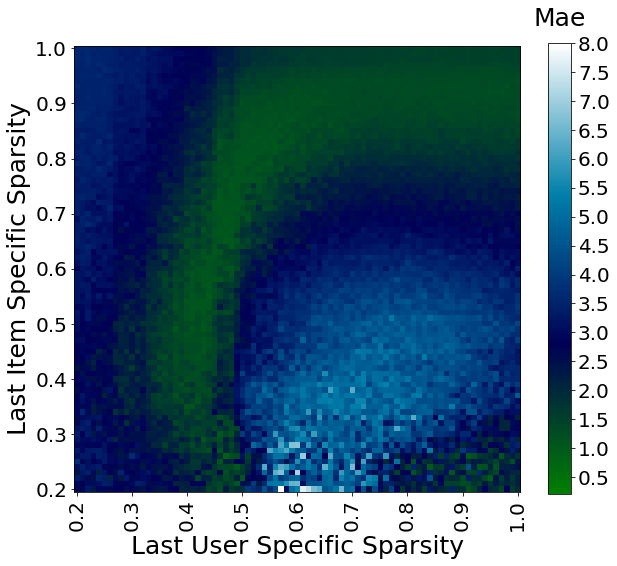

In [82]:
for column in arr_rating_metrics:

    arr_prec = joblib.load(dataset_output_folder + 'arr_' + column.lower() + '_' + model_name + '.joblib')        

    cmapping = "ocean"
    fig, ax = plt.subplots(figsize=(10,10))

    # plt.subplot(1, 1, 1)
    cax = plt.imshow(arr_prec, cmap=cmapping)
    plt.gca().invert_yaxis()
    cbar = plt.colorbar(cax, ticks = [x/100.0 for x in np.arange(0,1000,50)], shrink = 0.83)
    # plt.colorbar.set_label('OS', labelpad=-50,  y=1.05, rotation=0, fontsize = label_fontsize)

    tick_step = int(10)

    ax.set_xticklabels(uss_limits[0:len(uss_limits):tick_step])
    ax.set_yticklabels(iss_limits[0:len(uss_limits):tick_step])

    plt.xticks(np.arange(0, len(uss_limits), tick_step))
    plt.yticks(np.arange(0, len(iss_limits), tick_step))

    plt.clim(0.2, int(arr_prec.max())+1)


    tick_fontsize = 20
    label_fontsize = 25

    # # Setting Labels
    ax.set_xlabel('Last User Specific Sparsity', fontsize = label_fontsize)
    ax.set_ylabel('Last Item Specific Sparsity', fontsize = label_fontsize)
    # cbar = fig.colorbar(cax, ticks = [x/100.0 for x in np.arange(0,1000,5)])

    plt.xticks(rotation = 'vertical')
    ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)
    cbar.set_label(column.title(), labelpad=-50,  y=1.08, rotation=0, fontsize = label_fontsize)
    cbar.ax.tick_params(labelsize = tick_fontsize)


    # Saving figure
    filename = '2d-' + column + '-' + model_name + '.png';
    fullpath = dataset_output_folder+'Figures/';
    print ("[*] Saving " + filename + " figure to " + fullpath + " folder...")
    fig.savefig(fullpath + filename, bbox_inches = 'tight')
    print ("[+] Results saved.")
    
#     bot.send_photo(bot_credentials['chat_id'], photo=open(fullpath + filename, 'rb'))

In [ ]:
eval_model(**temp_eval_args)    

In [ ]:
df_ratings.head()

In [ ]:
sparsity_folders

In [ ]:
# filepath = "{}ratings.csv".format(folder)
# output_folder = '../Datasets/' + dataset + '/' + dataset_type + '/outputs/'
# dataset_output_folder = output_folder + 'sparsity_dataset/'

# # Visualize file content
# # df_whole = pd.read_csv(filepath, sep='\t', header=0, names=['user_id', 'item_id', 'rating', 'timestamp']) 
# df_whole = pd.read_csv(filepath, sep='\t', header=0) 
# df_whole.head()

In [ ]:

if not os.path.exists(dataset_output_folder):
    os.makedirs(dataset_output_folder)

### Item KNN Analysis

In [12]:
analysis_folder = sparsity_datasets_folder + sparsity_folders[-1] + '/folds/0/'

tr = analysis_folder + 'train.dat'
te = analysis_folder + 'test.dat'
predictions_output_filepath = './predictions_output.dat'

In [13]:
from caserec.recommenders.item_recommendation.itemknn import ItemKNN

model = ItemKNN(tr, te, k_neighbors=30,
                similarity_metric='cosine',
                output_file=predictions_output_filepath,
                rank_length=10)

model.compute(
    #metrics=('PREC', 'RECALL', 'MAP', 'NDCG'), 
    as_table=True,
    n_ranks=[10],
    verbose=True)

eval_results = model.evaluation_results

[Case Recommender: Item Recommendation > ItemKNN Algorithm]

train data:: 943 users and 1582 items (50000 interactions) | sparsity:: 96.65%
test data:: 943 users and 1583 items (50000 interactions) | sparsity:: 96.65%

training_time:: 3.983347 sec
prediction_time:: 29.855168 sec


PREC@10	RECALL@10	MAP@10	NDCG@10	
0.462248	0.133814	0.611684	0.727502	


In [16]:
from caserec.evaluation.rating_prediction import RatingPredictionEvaluation
from caserec.utils.process_data import ReadFile

reader = ReadFile(input_file=predictions_output_filepath)
predictions = reader.read()

# Creating evaluator with item-recommendation parameters
# evaluator = ItemRecommendationEvaluation

evaluator = RatingPredictionEvaluation(sep = '\t',                                       
                                       as_rank = False)

# Getting evaluation
eval_results = evaluator.evaluate(predictions['feedback'], model.test_set)

eval_results['MAE'] = model.evaluation_results['MAE']
eval_results['RMSE'] = model.evaluation_results['RMSE']

Eval:: MAE: 1.077314 RMSE: 1.324881 


In [18]:
model.evaluation_results

{'PREC@10': 0.462248,
 'RECALL@10': 0.133814,
 'NDCG@10': 0.727502,
 'MAP@10': 0.611684,
 'MAP': 0.611684}

In [ ]:
from caserec.evaluation.rating_prediction 

## Autoencoder Analysis 

In [ ]:
import os
os.listdir(dataset_folder)

In [ ]:
dataset_folder

In [ ]:

analysis_folder = sparsity_datasets_folder + sparsity_folders[-1] + '/folds/0/'

tr = analysis_folder + 'train.dat'
te = analysis_folder + 'train.dat'

model = AE(tr, te, kernel_initializer=initializers.random_uniform())
model.compute(verbose=True)

In [ ]:
step_size = 10
max_percentage = 0.8
array_eval_neurons = []
array_neurons = np.arange(10, int(max_percentage*len(model.items)), step_size)

for index, num_neurons in enumerate(array_neurons):
    clear_output()
    progbar.update_progress(index/float(len(array_neurons)))    
    
    model = AE(tr, te, num_neurons=num_neurons, kernel_initializer=initializers.random_uniform())
    model.compute(verbose=True)
    
    line = [num_neurons, model.evaluation_results['MAE'], model.evaluation_results['RMSE']]
    array_eval_neurons.append(line)
    
bot.send_message('Finished analsys RMSE and MAE for AutoEncoder')

In [ ]:
model_name = 'ae'
df_eval_neurons = pd.DataFrame(data=array_eval_neurons, columns=['neurons', 'MAE', 'RMSE'])
df_eval_neurons.to_csv(dataset_output_folder + 'df_eval_neurons_' + model_name + '.tsv', sep='\t', header=True)
df_eval_neurons.head()


In [ ]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10,10))
ax.plot(df_eval_neurons['neurons'], df_eval_neurons['MAE'], label='MAE')
ax.plot(df_eval_neurons['neurons'], df_eval_neurons['RMSE'], label='RMSE')
ax.legend()
ax.grid()
ax.set_title('Metrics x Number of Neurons')
ax.set_xlabel('Number of Neurons')

# Saving figure
filename = 'mae_rmse_x_num_neurons' + '-' + model_name + '.png';
fullpath = dataset_output_folder+'Figures/';
print ("[*] Saving " + filename + " figure to " + fullpath + " folder...")
fig.savefig(fullpath + filename, bbox_inches = 'tight')
print ("[+] Results saved.")

